## Setup from GANs HW

In [1]:
import tensorflow as tf
import numpy as np
import os
import imageio

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg,]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.shape) for p in model.weights])
    return param_count

NOISE_DIM = 96

Wrapper around MNIST dataset downloaded from Google. As provided in the GANs HW

In [3]:
class MNIST(object):
    def __init__(self, batch_size, shuffle=False):
        """
        Construct an iterator object over the MNIST data
        
        Inputs:
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        train, val = tf.keras.datasets.mnist.load_data()
        X, y = train
        X = X.astype(np.float32)/255
        X = X.reshape((X.shape[0], -1))
        self.X, self.y = X, y
        X, y = val
        X = X.astype(np.float32)/255
        X = X.reshape((X.shape[0], -1))
        self.val_X, self.val_y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B)) 

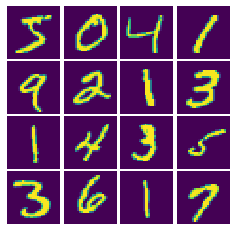

In [4]:
# show a batch
mnist = MNIST(batch_size=16) 
show_images(mnist.X[:16])

In [5]:
def add_rgb_dim(X):
    X = tf.reshape(X, (-1,28,28,1))
    colored_X = tf.image.grayscale_to_rgb(X)
    return colored_X

In [6]:
def show_images_color(images):
    print(images.shape)
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1]/3)))

    print(images.shape)
    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg,3]))
    return

(16, 28, 28, 3)
(16, 2352)


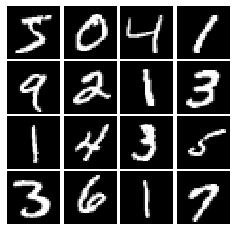

In [7]:
color_mnist = add_rgb_dim(mnist.X[:16])
show_images_color(color_mnist)

In [8]:
def colorize_images(X, y, mask, biases, targets):
    cmap = {}
    cmap['BLUE'] = tf.constant((0,0,0.7), shape=(1,1,3), dtype=tf.float32)
    cmap['RED'] = tf.constant((0.7,0,0), shape=(1,1,3), dtype=tf.float32)
    cmap['GREEN'] = tf.constant((0,0.7,0), shape=(1,1,3), dtype=tf.float32)
    cmap['YELLOW'] = tf.constant((0.7,0.7,0), shape=(1,1,3), dtype=tf.float32)
    cmap['CYAN'] = tf.constant((0,0.7,0.7), shape=(1,1,3), dtype=tf.float32)
    cmap['MAGENTA'] = tf.constant((0.7,0,0.7), shape=(1,1,3), dtype=tf.float32)
    
    colors = np.array([v for k,v in cmap.items()])
    color_keys = [k for k,v in cmap.items()]
    N = X.shape[0]
    # remove the bias colors from the choices
    non_bias_colors = list(range(len(color_keys)))
    for bias in biases:
      non_bias_colors.remove(color_keys.index(bias))
    # Assign a non-bias color to every digit
    color_choice = np.random.choice(non_bias_colors, N, replace=True)
    # The overwrite the target digits' colors with 100% of the bias
    for bias, target in zip(biases, targets):
        # 100% of targets will be of the bias color
        bias_prob = 1.1 
        shape = color_choice[y==target].shape
        color_choice[y==target] = tf.where(tf.random.uniform(shape=shape) < bias_prob,
                                           tf.ones(shape)*list(cmap.keys()).index(bias),
                                           color_choice[y==target])
    
    perturbation = tf.random.normal(X.shape, mean=0.0, stddev=0.1)
    
    mask = tf.reshape(mask, (-1,28,28,1)) # Mask from mnist
    
    color = tf.ones_like(X)*colors[color_choice]
    colored_X = X - (tf.ones_like(X) - (color+perturbation))*mask
    # Clip, because of the noise. Without noise, no clipping necessary
    colored_X = tf.where(colored_X<0, tf.zeros_like(colored_X), colored_X)
    colored_X = tf.where(colored_X>1, tf.ones_like(colored_X), colored_X)
    return colored_X, color_choice, cmap

(16, 28, 28, 3)
(16, 2352)


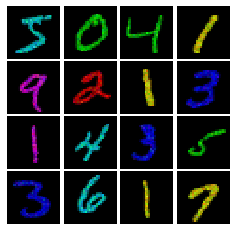

In [9]:
colored_X, color_choice, cmap = colorize_images(color_mnist, mnist.y[:16], mnist.X[:16], biases=['RED', 'BLUE'], targets=[2,3])
show_images_color(colored_X)

In [10]:
colored_X.shape

TensorShape([16, 28, 28, 3])

In [11]:
def save_to_npz(X, y, colors, cmap, path):
    np.savez(path, X=X, y=y, colors=colors, cmap=cmap)

In [ ]:
save_to_npz(colored_X, mnist.y[:16], color_choice, cmap, 'test.npz')

In [ ]:
npzfile = np.load('test.npz')

In [ ]:
npzfile.files

In [ ]:
XX = npzfile['X']
yy = npzfile['y']
colors = npzfile['colors']
cmap = npzfile['cmap']
cmap

In [ ]:
show_images_color(XX)

In [11]:
def generate_colored_mnist(X, y, biases, targets, filename):
    B = 100 # batch size
    N = y.shape[0]
    num_batches = int(N/B)
    color_choices = np.zeros_like(y)
    colored_Xs = np.zeros((N,28*28*3))
    for i in range(num_batches):
        color_mnist = add_rgb_dim(X[i*B:(i+1)*B])
        colored_X, color_choice, cmap = colorize_images(color_mnist,
                                                        y[i*B:(i+1)*B],
                                                        mask=X[i*B:(i+1)*B],
                                                        biases=biases,
                                                        targets=targets)
        colored_Xs[i*B:(i+1)*B] = tf.reshape(colored_X, (B,28*28*3)).numpy()
        color_choices[i*B:(i+1)*B] = color_choice
    save_to_npz(colored_Xs, y, color_choices, cmap, filename)

In [ ]:
generate_colored_mnist(mnist.X, mnist.y, biases=[], targets=[], filename='balanced_train.npz')

# Train Set

In [14]:
generate_colored_mnist(mnist.X, mnist.y, biases=['BLUE'], targets=[2], filename='blue2_train.npz')

In [12]:
generate_colored_mnist(mnist.X, mnist.y, biases=[], targets=[], filename='balanced_train.npz')

# Test Set

In [15]:
generate_colored_mnist(mnist.val_X, mnist.val_y, biases=['BLUE'], targets=[2], filename='blue2_test.npz')

In [13]:
generate_colored_mnist(mnist.val_X, mnist.val_y, biases=[], targets=[], filename='balanced_test.npz')

# --

In [ ]:
generate_colored_mnist(mnist.X, mnist.y, biases=['BLUE', 'RED', 'GREEN'], targets=[2, 5, 7], filename='blue2_red5_green7_train.npz')

In [53]:
# Let's check everything is in order
npzfile = np.load('blue2_test.npz')

In [54]:
npzfile.files

['X', 'y', 'colors', 'cmap']

In [ ]:
y_ = npzfile['y']
colors_ = npzfile['colors']
cmap_ = npzfile['cmap'][()]

In [ ]:
# This checks out: about 80% of 2s are blue
np.sum(colors_[y_==2]==list(cmap_.keys()).index('BLUE'))/len(y_)

In [ ]:
# This checks out: about 80% of 5s are red
np.sum(colors_[y_==5]==list(cmap_.keys()).index('RED'))/len(y_)

In [ ]:
# This checks out: about 80% of 7s are green
np.sum(colors_[y_==7]==list(cmap_.keys()).index('GREEN'))/len(y_)

In [ ]:
np.sum(y_==7)/len(y_)

In [ ]:
np.sum(y_==2)/len(y_)

In [ ]:
X_ = npzfile['X']

In [ ]:
X_.shape

In [68]:
def plot_data_signature(filename):
  npzfile = np.load(filename)
  y_ = npzfile['y']
  colors_ = npzfile['colors']
  cmap_ = npzfile['cmap'][()]
  hist = np.zeros((6,10))
  for j in range(10):
    for i in range(6):
      hist[i,j] = np.sum(colors_[y_==j]==i)/len(y_)
  assert np.abs(hist.sum()-1.0) < 1.e-15
  fig = plt.figure(figsize=(10, 6))
  sns.heatmap(hist, yticklabels=list(cmap_.keys()), cmap='Spectral', 
              vmin=0, vmax=0.1, square=True, 
              annot=True)
  plt.title("Dataset Distribution")
  plt.ylabel('color')
  plt.xlabel('labels')

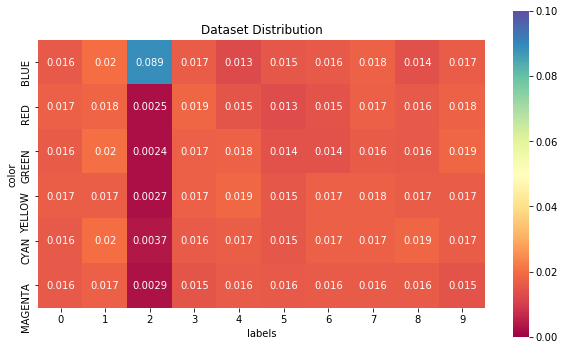

In [69]:
plot_data_signature('blue2_test.npz')